In [1]:
%matplotlib inline

from config import configs

import os
import io
import matplotlib
import timeit
import random
import pprint
import knn
import cv2
import deepdish as dd
import numpy as np
import matplotlib.pyplot as plt

from numba import njit, prange, jit
from datetime import datetime
from skimage.transform import resize
from scipy.interpolate import griddata
from core.kitti import KITTI
from core.transforms_3D import transform, project
from pixor_utils.model_utils import load_model, save_model
from data_utils.training_gen import TrainingGenerator
from data_utils.generator import Generator, KITTIGen
from tt import bev
from pixor_targets import PIXORTargets
from pixor_utils.post_processing import nms_bev
from test_utils.unittest import test_pc_encoder, test_target_encoder
from encoding_utils.pointcloud_encoder import OccupancyCuboidKITTI
from encoding_utils.voxelizer import BEVVoxelizer

In [2]:
# c = 3
# np.random.seed(0)
# for n in range(1):
#     query = np.random.rand(c, 56*64).astype(np.float32)
#     # print('query.shape', query.shape)
#     reference = np.random.rand(c, 20000).astype(np.float32)
#     # print('reference.shape', reference.shape)

#     s = timeit.default_timer()
#     # Index is 1-based
#     dist, ind = knn.knn(query,
#                         reference, 
#                         1)

#     # print('took', timeit.default_timer() - s)
#     print(dist.shape, ind.shape)
#     pprint.pprint(ind.T)
#     pprint.pprint(dist.T)

In [3]:
DS_DIR = os.path.expanduser(configs['dataset_path'])

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

In [4]:
import tensorflow as tf
import tensorflow.keras.backend as K

device_name = tf.test.gpu_device_name()
os.system('clear')
print('Conncted to Device:', device_name)

Conncted to Device: /device:GPU:0


In [5]:
# Point Cloud Encoder
INPUT_SHAPE = configs['input_shape']

# Training
BATCH_SIZE = configs['hyperparams']['batch_size']
LEARNING_RATE = configs['hyperparams']['lr']
EPOCHS = configs['hyperparams']['epochs']
NUM_THREADS = configs['hyperparams']['num_threads']
MAX_Q_SIZE = configs['hyperparams']['max_q_size']

In [6]:
kitti = KITTI(DS_DIR, configs['training_target'])

train_ids = kitti.get_ids('train')
val_ids = kitti.get_ids('val')
micro_ids = kitti.get_ids('micro')

In [7]:
pc_encoder = OccupancyCuboidKITTI(0, 70, -40, 40, -1, 3, [0.1, 0.1, 4]) # 0.1, 0.1, 0.4
voxelizer  = BEVVoxelizer(n_x=448, n_y=512, n_z=32, side_range=(0,70), fwd_range=(-40,40), height_range=(-1, 3), filter_external=True)

In [8]:
cur_idx = train_ids[25]

In [9]:
pc, ref = kitti.get_velo(cur_idx, workspace_lim=((-40, 40), (-1, 3), (0, 70)), use_fov_filter=True)
print('pc.shape', pc.shape, 'ref.shape', ref.shape)

pc.shape (3, 17369) ref.shape (1, 17369)


In [10]:
encoded_pc = pc_encoder.encode(pc.T)
print('encoded_pc.shape', encoded_pc.shape)

encoded_pc.shape (700, 800, 1)


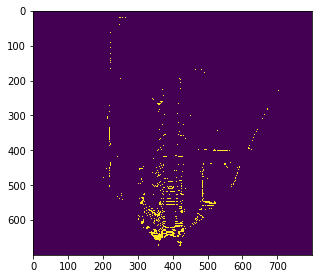

In [11]:
plt.figure(figsize = (5, 5))
plt.imshow(np.squeeze(encoded_pc))

In [12]:
voxelized_pc = voxelizer.encode(pc)

In [13]:
print(np.sum(voxelized_pc))
print(voxelized_pc.shape)

7396.0
(448, 512, 32)


In [14]:
bev = np.sum(voxelized_pc, axis=2)
bev = bev / np.amax(bev)
print('bev.shape', bev.shape)
print(np.amin(bev), np.amax(bev), np.mean(bev))
print(np.amin(encoded_pc), np.amax(encoded_pc), np.mean(encoded_pc))

bev.shape (448, 512)
0.0 1.0 0.0023031428
0.0 1.0 0.0121535715


In [15]:
def bev2world(idx, jdx, bev_width, bev_length, world_width, world_length):
    disc_factor_w, disc_factor_l = world_width / bev_width, world_length / bev_length
    x = idx * disc_factor_w - world_width / 2.
    z = (bev_length - jdx) * disc_factor_l
    return np.array([x, 0.5, z])
#     return idx * disc_factor_w - world_width / 2., 1., (bev_length - jdx) * disc_factor_l
cur_idx = train_ids[25]

In [16]:
# pt = bev2world(512 // 4, 448 // 4, 512 // 4, 448 // 4, 80, 70)
# pt.tolist(), get_nearest_pt(pt.reshape((3, 1)), pc).tolist()

In [17]:
_, _, P2 = kitti.get_calib(cur_idx)

In [19]:
def get_nearest_neighbour(pt_cloud, bev_width, bev_length, image_downsampling_factor, P2, parts=4):
    if pt_cloud.shape[0] != 3:
        pt_cloud = pt_cloud.T
    world_pts = []
    # one time for each dim
    for i in range(bev_length):
        for j in range(bev_width):
            world_pts.append(bev2world(j, i, bev_width, bev_length, 80, 70))
    all_inds = []
    for i in range(parts):
        cur_part = np.array(world_pts[i * len(world_pts) // parts:i * len(world_pts) // parts + len(world_pts) // parts]).T
        _, inds = knn.knn(cur_part.astype(np.float32),
                          pt_cloud.astype(np.float32),
                          1)
        inds = np.squeeze(inds) - 1
        all_inds = all_inds + inds.tolist()
    world_pts = np.array(world_pts).T
    nearest = pt_cloud[:,all_inds]
    return world_pts, nearest
    
def get_contfuse_data(pt_cloud, bev_width, bev_length, image_downsampling_factor, P2, parts=4):
    world_pts, nearest = get_nearest_neighbour(pt_cloud, bev_width, bev_length, image_downsampling_factor, P2, parts=4)
    print('world_pts.shape', world_pts.shape)
    print('nearest.shape  ', nearest.shape)
    geo_feature = nearest - world_pts
    nearest_projected = project(P2, nearest).astype(np.int32).T // image_downsampling_factor
    return {
        'mapping': nearest_projected.reshape((bev_length, bev_width, 2)),
        'geo_feature': geo_feature.reshape((bev_length, bev_width, 3))
    }

factor = 2
print(bev.shape[0] // factor, bev.shape[1] // factor)
start = timeit.default_timer()
pc, _ = kitti.get_velo(cur_idx, workspace_lim=((-40, 40), (-1, 3), (0, 70)), use_fov_filter=True)
result2x = get_contfuse_data(pc, bev.shape[1] // 2, bev.shape[0] // 2, 2, P2, 4)
result4x = get_contfuse_data(pc, bev.shape[1] // 4, bev.shape[0] // 4, 4, P2, 4)
result8x = get_contfuse_data(pc, bev.shape[1] // 8, bev.shape[0] // 8, 8, P2, 4)
# print(np.amin(mapping[:,:,0]), np.amax(mapping[:,:,0]))
# print(np.amin(mapping[:,:,1]), np.amax(mapping[:,:,1]))

mapping2x, geo2x = result2x['mapping'], result2x['geo_feature']
mapping4x, geo4x = result4x['mapping'], result4x['geo_feature']
mapping8x, geo8x = result8x['mapping'], result8x['geo_feature']

mapping2x[:,:,(0,1)] = mapping2x[:,:,(1,0)]
mapping4x[:,:,(0,1)] = mapping4x[:,:,(1,0)]
mapping8x[:,:,(0,1)] = mapping8x[:,:,(1,0)]
# print(np.amin(mapping[:,:,0]), np.amax(mapping[:,:,0]))
# print(np.amin(mapping[:,:,1]), np.amax(mapping[:,:,1]))
# print(mapping.shape)
print('took', timeit.default_timer() - start)

224 256
world_pts.shape (3, 57344)
nearest.shape   (3, 57344)
world_pts.shape (3, 14336)
nearest.shape   (3, 14336)
world_pts.shape (3, 3584)
nearest.shape   (3, 3584)
took 0.40775617212057114


In [18]:
# mapping2x, mapping4x, mapping8x, _, _, _ = kitti.get_contfuse_preprocessing(cur_idx)
world_pts2x, world_pts4x, world_pts8x, nearest2x, nearest4x, nearest8x = kitti.get_contfuse_nearest(cur_idx)
mapping2x, geo2x = kitti.compute_contfuse_mapping(cur_idx, world_pts2x, nearest2x, 256, 224, 2)
mapping4x, geo4x = kitti.compute_contfuse_mapping(cur_idx, world_pts4x, nearest4x, 128, 112, 4)
mapping8x, geo8x = kitti.compute_contfuse_mapping(cur_idx, world_pts8x, nearest8x, 64, 56, 8)
img = kitti.get_image(cur_idx)
img2x = cv2.resize(img, (621, 188))
img4x = cv2.resize(img, (311, 94))
img8x = cv2.resize(img, (156, 47))
# bev_im = np.zeros((224, 256, 3))
# for i in range(224):
#     for j in range(256):
#         bev_im[i,j] = img[mapping2x[i,j][1], mapping2x[i,j][0]]

print('mapping2x.shape', mapping2x.shape)
print(np.amin(mapping2x[:,:,0]), np.amax(mapping2x[:,:,0]))
print(np.amin(mapping2x[:,:,1]), np.amax(mapping2x[:,:,1]))
print('------------------')
print('mapping4x.shape', mapping4x.shape)
print(np.amin(mapping4x[:,:,0]), np.amax(mapping4x[:,:,0]))
print(np.amin(mapping4x[:,:,1]), np.amax(mapping4x[:,:,1]))
print('------------------')
print('mapping8x.shape', mapping8x.shape)
print(np.amin(mapping8x[:,:,0]), np.amax(mapping8x[:,:,0]))
print(np.amin(mapping8x[:,:,1]), np.amax(mapping8x[:,:,1]))
print('------------------')
        
bev_im1 = np.zeros((224, 256, 3))
bev_im2 = np.zeros((112, 128, 3))
bev_im3 = np.zeros((56, 64, 3))
for i in range(224):
    for j in range(256):
        bev_im1[i,j] = img2x[mapping2x[i,j,0], mapping2x[i,j,1]]
for i in range(112):
    for j in range(128):
        bev_im2[i,j] = img4x[mapping4x[i,j,0], mapping4x[i,j,1]]
for i in range(56):
    for j in range(64):
        bev_im3[i,j] = img8x[mapping8x[i,j,0], mapping8x[i,j,1]]

mapping2x.shape (224, 256, 2)
67 187
0 620
------------------
mapping4x.shape (112, 128, 2)
33 93
0 310
------------------
mapping8x.shape (56, 64, 2)
16 46
0 155
------------------


In [19]:
new_img1 = tf.gather_nd(img2x, mapping2x).numpy()
new_img2 = tf.gather_nd(img4x, mapping4x).numpy()
new_img3 = tf.gather_nd(img8x, mapping8x).numpy()

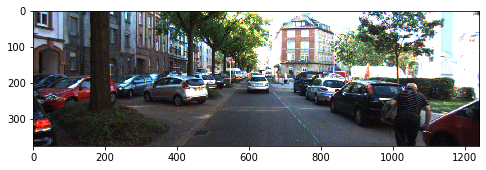

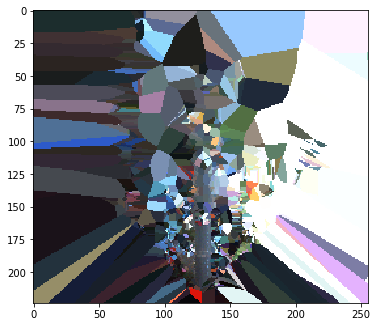

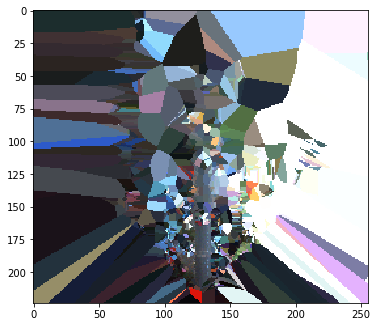

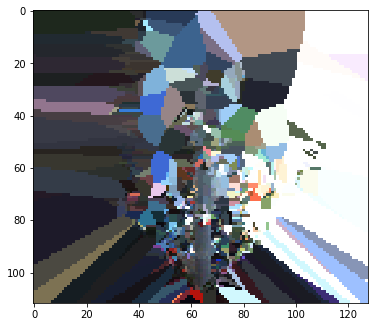

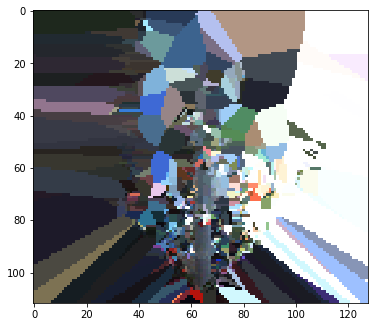

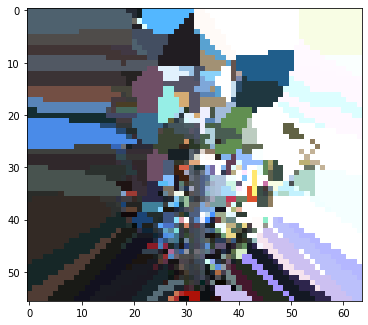

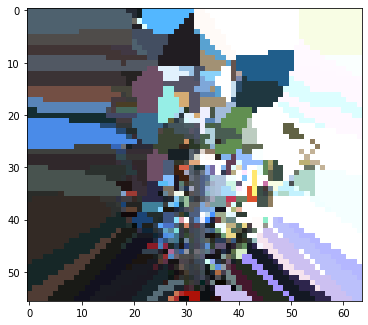

In [20]:
plt.figure(figsize = (8, 8))
plt.imshow(img)

# plt.figure(figsize = (6, 6))
# plt.imshow(bev_im)

plt.figure(figsize = (6, 6))
plt.imshow(bev_im1)
plt.figure(figsize = (6, 6))
plt.imshow(new_img1)

plt.figure(figsize = (6, 6))
plt.imshow(bev_im2)
plt.figure(figsize = (6, 6))
plt.imshow(new_img2)

plt.figure(figsize = (6, 6))
plt.imshow(bev_im3)
plt.figure(figsize = (6, 6))
plt.imshow(new_img3)

In [ ]:
# print('mapping.shape', mapping.shape, 'geo_feat.shape', geo_feat.shape)
# print('mapping.dtype', mapping.dtype, 'geo_feat.dtype', geo_feat.dtype)
# for i, id in enumerate(train_ids + val_ids):
#     pc, _ = kitti.get_velo(id, workspace_lim=((-40, 40), (-1, 3), (0, 70)), use_fov_filter=True)
# #     img = kitti.get_image(id)
# #     img = cv2.resize(img, (311, 94))
# #     print('img.shape', img.shape)
#     mapping2x, geo_feat2x = get_world_pts(pc, bev.shape[1] // 2, bev.shape[0] // 2, factor, P2)
#     mapping4x, geo_feat4x = get_world_pts(pc, bev.shape[1] // 4, bev.shape[0] // 4, factor, P2)
#     mapping8x, geo_feat8x = get_world_pts(pc, bev.shape[1] // 8, bev.shape[0] // 8, factor, P2)
# #     print(mapping2x.shape, geo_feat2x.shape)
# #     print(mapping4x.shape, geo_feat4x.shape)
# #     print(mapping8x.shape, geo_feat8x.shape)
#     np.savez_compressed('preprocessed_data/cont_fuse/{}'.format(id), 
#                         mapping2x=mapping2x,
#                         mapping4x=mapping4x,
#                         mapping8x=mapping8x,
#                         geo_feat2x=geo_feat2x,
#                         geo_feat4x=geo_feat4x,
#                         geo_feat8x=geo_feat8x,)
#     print(i, id)

In [ ]:
# factor = 2
# new_bev = np.zeros((bev.shape[0] // factor, bev.shape[1] // factor, 3))
# print(mapping2x.shape, new_bev.shape)
# print(np.amin(mapping2x), np.amax(mapping2x))
# for i in range(mapping2x.shape[0]):
#     for j in range(mapping2x.shape[1]):
#         new_bev[i,j] = img[int(mapping2x[i,j,1]), int(mapping2x[i,j,0])]
# plt.figure(figsize = (8, 8))
# plt.imshow(new_bev)

In [ ]:
# img = kitti.get_image(id)
# img = cv2.resize(img, (311, 94))
# print('img.shape', img.shape)

# plt.figure(figsize = (8, 8))
# plt.imshow(img)

In [ ]:
# plt.figure(figsize = (15, 15))
# plt.imshow(bev)

In [ ]:
# plt.figure(figsize = (20,20))
# plt.imshow(np.squeeze(encoded_pc))

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 20))
# # ax1.axis('off')
# ax1.imshow(np.squeeze(bev), cmap='gray')
# # ax2.axis('off')
# ax2.imshow(np.squeeze(encoded_pc), cmap='gray')